# Experimentation RFC

## Data
For this RFC, the data used in this capstone project is a 58 day, de-identified capture of users, computers, and processes on a network. The data was retrieved from Windows endpoints/computers on the network and although de-identified, maintain similar information to what can be found in normal Windows Security Event Logs. This particular data, for individual computer systems directly translate to Windows start and stop event IDs: 4688 and 4689. These represent granular workstation activity and can be used to identify what happens on the workstation after the user has logged in. The data do not include full path information of the processes themselves, nor does it include command options that may have been used during process start events. The data was made available from Los Alamos National Laboratory, and can be retrieved here: https://csr.lanl.gov/data/cyber1/

A. D. Kent, “Comprehensive, Multi-Source Cybersecurity Events,” Los Alamos National Laboratory, http://dx.doi.org/10.17021/1179829, 2015.

## Hypothesis
Certain groups of users would normally run similar processes, and other groups of users may run very similar processes.  The hypothesis is that groups of users running processes can be identified, and those users who look least like any other group can be identified as being anomalous.

## Rollout Plan
In order to collect the data needed for this analysis, Windows Security Event logs would have to be collected off of endpoint computers on a network and centralized.  This would involve setting security audit settings on the endpoints themselves or, more effectively, setting a policy at the Domain level using Group Policy Objects (GPO) that specify the exact events to log. Additionally, configuration settings on permissions on who or what can change the logs would need to be set to ensure logging integrity.  This is typically set again at the Domain level using GPOs.  Finally, the centralized logging facility itself would need to be appropriately configured to ensure no changes are made to the logs.  

##  Evaluation Plan
If anomalous users are identified, success in this experiment is achieved.  Subject Matter Experts will validate the results of this and provide feedback.  Distributions between normal and anomalous users' processes will be provided.  The data is not labeled, thus, this requires SME expertise.

## Analysis
The following constitues the analysis of this experiment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.neighbors import NearestNeighbors


%matplotlib inline

In [2]:
columns = ['time', 'username', 'computer', 'process_name', 'start_or_stop']
df = pd.read_csv("C:\\Users\\kim\\data\\proc.txt", nrows=50000)
df.columns=columns

In [3]:
copy_df = df
del copy_df['time']
del copy_df['computer']
del copy_df['start_or_stop']
for x in copy_df.process_name.unique():
    copy_df[x]=(copy_df.process_name==x).astype(int)
del copy_df['process_name']
final_matrix = copy_df.groupby(['username']).max()
final_matrix.head()

,P4,P3,P16,P37,P5,P8,P96,P7,P11,P47,...,P333,P312,P174,P323,P315,P319,P320,P270,P330,P339
username,,,,,,,,,,,,,,,,,,,,,
C1$@DOM1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C10$@DOM1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
C100$@DOM1,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1000$@DOM1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1001$@DOM1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


You can see after the transformation of the data that different users used different processes during the duration of the data capture.  Some users appear to run similar processes, for example, user C1000\$@DOM1 and C1001\$@DOM1.  Some users use different sets of processes, for example C10$@DOM1 and C1@DOM1.  

In [4]:
def euclidean_distance(user, df):
    result_df = pd.DataFrame(columns=['username','compared_user','distance'])
    mylist = []
    for i in df.index:
        distance = np.linalg.norm(df.loc[user]-final_matrix.loc[i])
        mylist.append([user, i, distance])
    result_df = pd.DataFrame(mylist, columns = ['username','compared_user','distance'])    
    return result_df

In [5]:
user = 'C1001$@DOM1'
result_df = euclidean_distance(user, final_matrix)

temp_copy = result_df.copy()
temp_copy.set_index('compared_user', inplace=True)
final_matrix = pd.merge(final_matrix, temp_copy, right_index=True, left_index=True, how='outer')
del final_matrix['username']
final_matrix.head()

,P4,P3,P16,P37,P5,P8,P96,P7,P11,P47,...,P312,P174,P323,P315,P319,P320,P270,P330,P339,distance
username,,,,,,,,,,,,,,,,,,,,,
C1$@DOM1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.449490
C10$@DOM1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.162278
C100$@DOM1,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2.000000
C1000$@DOM1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.414214
C1001$@DOM1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


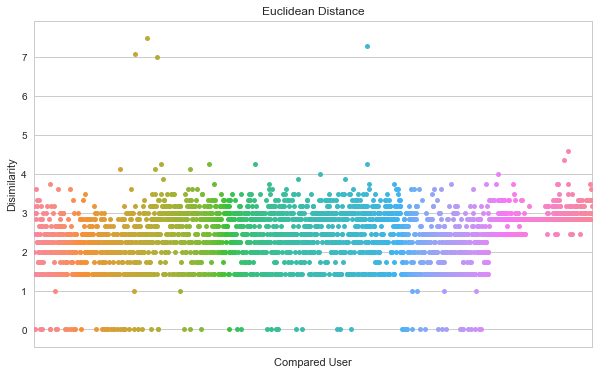

In [6]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
g = sns.swarmplot(x='compared_user', y ='distance', data = result_df)
g.set_xticklabels([])
plt.title('Euclidean Distance')
plt.xlabel('Compared User')
plt.ylabel('Disimilarity')

From this diagram you can clearly see that there are various "bands" of users.  There are users that are exactly the same, i.e., the distance between them is zero and then there are those users who are very dissimilar, i.e., users that have a disimilary of over 7.

This shows us the difference between users and the single user, C1001$@DOM1. This diagram, at least partially shows that the hypothesis should work.  In order to continue, however, we need to reduce our dimensionality to ensure we get accuracy of the results and try to avoid the "curse of dimensionality".  In order to do this, we complete Principal Component Analysis (PCA).

In [7]:
def get_cummulative_variance(n):
    X = final_matrix.values
    pca = PCA(n_components=n)
    pca.fit(X)

    variance = pca.explained_variance_ratio_
    cummulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    return cummulative_variance

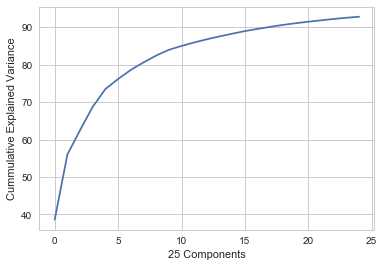

In [8]:
cummulative_variance = get_cummulative_variance(25)
plt.plot(cummulative_variance)
plt.xlabel("25 Components")
plt.ylabel("Cummulative Explained Variance")
plt.subplots_adjust(top=0.9)
plt.show()

In [9]:
def rank_features(data, n_components): 
    features = data 
    feature_names = features.columns.tolist() 
    pca = PCA(n_components=n_components) 
    pca.fit(features) 
    variances = pca.explained_variance_ratio_ 
    variances = list(zip(feature_names, variances))
    df = pd.DataFrame(variances, columns=['feature', 'variance_ratio']).set_index('feature') 
    df = df.sort_values('variance_ratio', ascending=False) 
    return df

In [10]:
ranked_features = rank_features(final_matrix, 311)
ranked_features.head(25)

,variance_ratio
feature,
P4,0.386242
P3,0.173803
P16,0.065218
P37,0.062497
P5,0.047314
P8,0.026661
P96,0.024344
P7,0.020033
P11,0.018267


From PCA analysis, you can see that the top 25 features explain most of the variance.  For the purposes of this Capstone, we will use these features to perform Local Outlier Factor Analysis.  Using feature selection, we can narrow down the data set.  

In [11]:
new_df = final_matrix[['P4', 'P3','P16','P37','P5','P8','P98','P7','P11','P47','P25','P20','P1','P59','P9','P21','P27','P26','P22','P17','P18','P193','P154','P194','P198']].copy()
new_df.head()

,P4,P3,P16,P37,P5,P8,P98,P7,P11,P47,...,P21,P27,P26,P22,P17,P18,P193,P154,P194,P198
username,,,,,,,,,,,,,,,,,,,,,
C1$@DOM1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C10$@DOM1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
C100$@DOM1,1,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1000$@DOM1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1001$@DOM1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def knn(df, k):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(df)
    distances, indices = neighbors.kneighbors(df)
    return distances, indices

def reachDistance(df, min_points, knn_distances):
    neighbors = NearestNeighbors(n_neighbors=min_points)
    neighbors.fit(df)
    distances_min_points, indices_min_points = neighbors.kneighbors(df)
    #np.amax returns the maximum of an array or maximum along an axis
    distances_min_points[:,0] = np.amax(distances_min_points, axis=1)
    distances_min_points[:,1] = np.amax(distances_min_points, axis=1)
    distances_min_points[:,2] = np.amax(distances_min_points, axis=1)
    return distances_min_points, indices_min_points

def local_reachability_density(min_points, knn_distances):
    # np.divide would help with the infinity problem
    return (np.divide(min_points,np.sum(knn_distances, axis=1)))

def local_outlier_factor(lrd, min_points, distances):
    lof=[]
    for item in distances:
        tempLrd = np.divide(lrd[item[1:]], lrd[item[0]])
        lof.append(np.divide(tempLrd.sum(),min_points))
    return lof

In [13]:
minimum_points = 3

knn_distances, knn_indices = knn(new_df, 3)
reach_distances, reach_indices = reachDistance(new_df, 3, knn_distances)
lrd_matrix = local_reachability_density(minimum_points, reach_distances)
lof_scores = local_outlier_factor(lrd_matrix, minimum_points, reach_indices)

scores_df = pd.DataFrame(lof_scores, columns=['Score'])
scores_df = scores_df.fillna(0)

C:\Users\kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


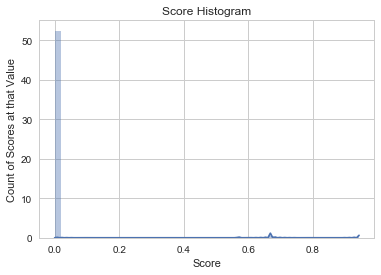

In [14]:
scores_df = scores_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Score'], how="all")
sns.distplot(scores_df['Score'])
plt.xlabel('Score')
plt.ylabel('Count of Scores at that Value')
plt.title('Score Histogram')

You can see from the histogram above that there are a lot of scores at zero.  Since we are looking for outliers or anomalies, we will remove this score from the dataframe and redisplay.

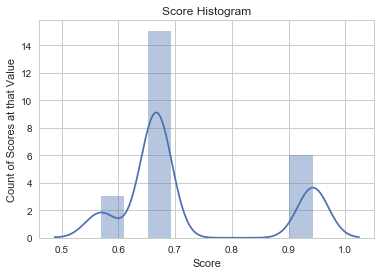

In [15]:
merged_removed_lower_ones = scores_df[(scores_df['Score']>0)]
sns.distplot(merged_removed_lower_ones['Score'])
plt.xlabel('Score')
plt.ylabel('Count of Scores at that Value')
plt.title('Score Histogram')

Rescaling the diagram shows that there are outliers in this data.  Now we will further investigate this data.

In [16]:
final_matrix.reset_index(inplace=True)

In [17]:
merged = pd.merge(scores_df, final_matrix, left_index=True, right_index=True)

In [18]:
outliers = merged[merged['Score']>0.9]

In [25]:
final_comparison = outliers[['P4', 'P3','P16','P37','P5','P8','P98','P7','P11','P47','P25','P20','P1','P59','P9','P21','P27','P26','P22','P17','P18','P193','P154','P194','P198']].copy()

In [26]:
final_comparison

,P4,P3,P16,P37,P5,P8,P98,P7,P11,P47,...,P21,P27,P26,P22,P17,P18,P193,P154,P194,P198
1646,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1795,0,1,1,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1838,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1892,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2227,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2361,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2372,0,0,1,0,1,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2855,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


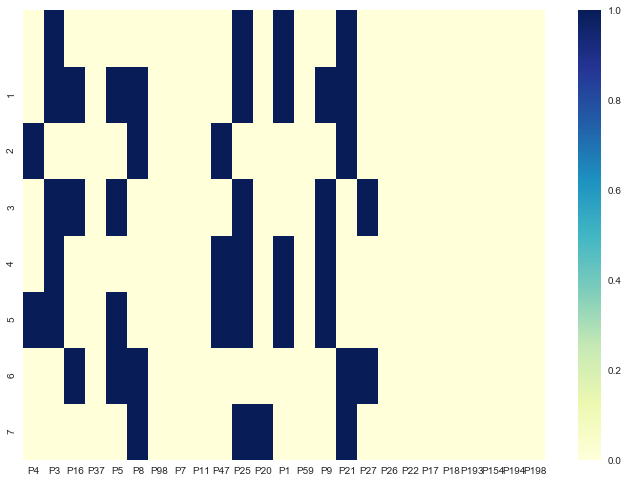

In [30]:
# Use a heatmap
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(final_comparison, cmap="YlGnBu", xticklabels=['P4', 'P3','P16','P37','P5','P8','P98','P7','P11','P47','P25','P20','P1','P59','P9','P21','P27','P26','P22','P17','P18','P193','P154','P194','P198'], yticklabels=['1','2','3','4','5','6','7'])

In [45]:
random_sample = final_matrix.sample(8)
random_sample = random_sample[['P4', 'P3','P16','P37','P5','P8','P98','P7','P11','P47','P25','P20','P1','P59','P9','P21','P27','P26','P22','P17','P18','P193','P154','P194','P198']]
random_sample.describe()

,P4,P3,P16,P37,P5,P8,P98,P7,P11,P47,...,P21,P27,P26,P22,P17,P18,P193,P154,P194,P198
count,8.000000,8.000000,8.000000,8.0,8.000000,8.00000,8.0,8.00000,8.0,8.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
mean,0.125000,0.125000,0.500000,0.0,0.375000,0.25000,0.0,0.25000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.353553,0.353553,0.534522,0.0,0.517549,0.46291,0.0,0.46291,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.500000,0.0,0.000000,0.00000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.000000,1.000000,0.0,1.000000,0.25000,0.0,0.25000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,0.0,1.000000,1.00000,0.0,1.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
random_sample.sum(axis=1).sum()/8

2.25

In [44]:
final_comparison.sum(axis=1).sum()/8

5.375

Taking a random sample of 8 users, they were running an average of 2.25 processes.  The outliers identified in this analysis users ran an average of 5.375 processess, more than the random sample.